In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## The Framework of Hypothesis Testing

Hypothesis testing is a core concept in inferential statistics. It provides a structured way to make decisions when faced with uncertainty. A common application is **A/B testing**, where a "control" group is compared to a "treatment" group to determine if a change had a real effect. The fundamental question is always the same: "Is the difference I observed in my sample a real effect, or is it just a result of random sampling variability?"

The process begins with a **hypothesis** about a population parameter. For example, we might hypothesize that the mean annual compensation for a population of data scientists is $110,000.

We then take a sample from that population and calculate a **point estimate** (the sample mean). If our sample mean is very close to the hypothesized mean, we have no reason to doubt the hypothesis. However, if our sample mean is very far from the hypothesized value, we might conclude that our initial hypothesis was wrong.


### Using the Bootstrap Distribution to Estimate Variability

To decide what constitutes "far," we need to understand how much our sample mean is expected to vary by chance alone. The **standard error** quantifies this variability. As we've seen, we can estimate the standard error by generating a **bootstrap distribution** from our sample. The standard deviation of this bootstrap distribution is our best estimate of the standard error.

```python
import pandas as pd
import numpy as np

# Create a generic "sample" DataFrame
np.random.seed(42)
sample = pd.DataFrame({
    'compensation': np.random.normal(loc=120000, scale=50000, size=500)
})

# Generate a bootstrap distribution of the sample mean
bootstrap_dist = []
for i in range(5000):
    bootstrap_sample = sample.sample(frac=1, replace=True, random_state=i)
    bootstrap_dist.append(bootstrap_sample['compensation'].mean())

# The standard deviation of the bootstrap distribution is the standard error
standard_error = np.std(bootstrap_dist, ddof=1)
print(f"Estimated Standard Error: {standard_error:.2f}")
```


### The Z-Score: Standardizing the Difference

The **z-score** is a standardized test statistic that reframes the difference between our sample statistic and the hypothesized parameter in units of standard errors. This allows us to assess how "surprising" our sample result is.

The formula is:
$$z = \frac{\text{Sample Statistic} - \text{Hypothesized Parameter Value}}{\text{Standard Error}}$$

A z-score of 2.5 means our observed sample statistic is 2.5 standard errors away from the hypothesized value.

```python
# Calculate the z-score 

# Our hypothesis about the population
hypothesized_mean = 110000

# Our observed statistic from the sample
sample_mean = sample['compensation'].mean()

# Calculate the z-score
z_score = (sample_mean - hypothesized_mean) / standard_error

print(f"Sample Mean: {sample_mean:.2f}")
print(f"Hypothesized Mean: {hypothesized_mean}")
print(f"Z-score: {z_score:.4f}")
```

### Interpreting the Z-Score

To determine if our z-score is large or small, we compare it to the **standard normal distribution**, which is a normal distribution with a mean of 0 and a standard deviation of 1. If our original hypothesis were true, we would expect our z-score to be a value that could plausibly come from this distribution (i.e., a value close to zero).

A common threshold for statistical significance is a z-score whose absolute value is greater than **1.96**. This value corresponds to the middle 95% of the standard normal distribution. A z-score outside this range is considered unlikely to have occurred by random chance alone if the hypothesis were true.

  * If `|z| > 1.96`, we typically **reject the hypothesis**. The evidence suggests the true population parameter is different from what was hypothesized.
  * If `|z| ≤ 1.96`, we **fail to reject the hypothesis**. The observed difference is small enough that it could plausibly be due to random sampling variability.

In our example, the calculated z-score is greater than 1.96, so we would reject the hypothesis that the true mean compensation is $110,000. Our sample provides strong evidence that the true mean is likely higher.

In [2]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/c59033b93930652f402e30db77c3b8ef713dd701/stack_overflow.feather"
stack_overflow = pd.read_feather(url)
stack_overflow.head()

,respondent,main_branch,hobbyist,age,age_1st_code,age_first_code_cut,comp_freq,comp_total,converted_comp,country,...,survey_length,trans,undergrad_major,webframe_desire_next_year,webframe_worked_with,welcome_change,work_week_hrs,years_code,years_code_pro,age_cat
0,36.0,"I am not primarily a developer, but I write co...",Yes,34.0,30.0,adult,Yearly,60000.0,77556.0,United Kingdom,...,Appropriate in length,No,"Computer science, computer engineering, or sof...",Express;React.js,Express;React.js,Just as welcome now as I felt last year,40.0,4.0,3.0,At least 30
1,47.0,I am a developer by profession,Yes,53.0,10.0,child,Yearly,58000.0,74970.0,United Kingdom,...,Appropriate in length,No,"A natural science (such as biology, chemistry,...",Flask;Spring,Flask;Spring,Just as welcome now as I felt last year,40.0,43.0,28.0,At least 30
2,69.0,I am a developer by profession,Yes,25.0,12.0,child,Yearly,550000.0,594539.0,France,...,Too short,No,"Computer science, computer engineering, or sof...",Django;Flask,Django;Flask,Just as welcome now as I felt last year,40.0,13.0,3.0,Under 30
3,125.0,"I am not primarily a developer, but I write co...",Yes,41.0,30.0,adult,Monthly,200000.0,2000000.0,United States,...,Appropriate in length,No,None,None,None,Just as welcome now as I felt last year,40.0,11.0,11.0,At least 30
4,147.0,"I am not primarily a developer, but I write co...",No,28.0,15.0,adult,Yearly,50000.0,37816.0,Canada,...,Appropriate in length,No,"Another engineering discipline (such as civil,...",None,Express;Flask,Just as welcome now as I felt last year,40.0,5.0,3.0,Under 30


In [3]:
# Generating a bootstrap distribution
# This simulates the sampling distribution of the mean compensation by repeatedly resampling (with replacement)
# from the stack_overflow dataset and calculating the mean for each resample.
so_boot_distn = [
    np.mean(stack_overflow.sample(frac=1, replace=True)["converted_comp"])
    for _ in range(5000)
]

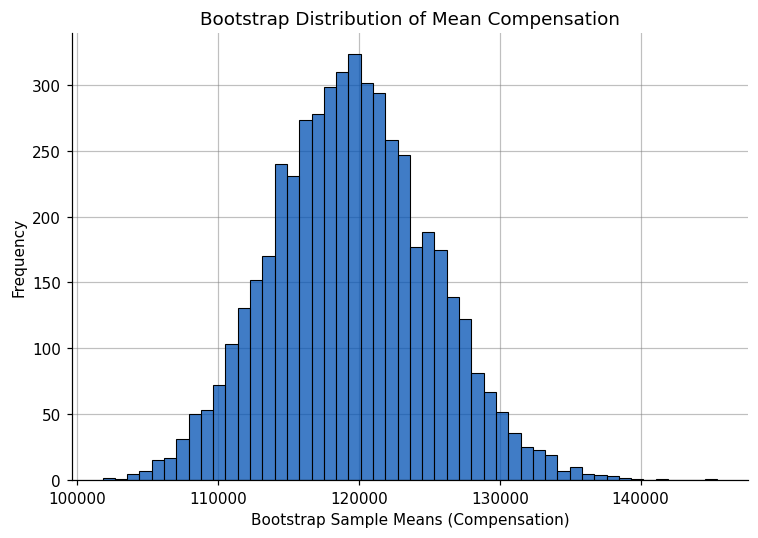

In [4]:
# Plotting the bootstrap distribution of sample means for compensation

fig, ax = plt.subplots(figsize=(7, 5), dpi=110)

# Plot a histogram of the bootstrap sample means
sns.histplot(so_boot_distn, bins=50, ax=ax, color="#0050B3", edgecolor="black")
sns.despine()

# Set axis labels and title
ax.set(
    xlabel="Bootstrap Sample Means (Compensation)",
    ylabel="Frequency",
    title="Bootstrap Distribution of Mean Compensation",
)

# Add gridlines
ax.grid(True, alpha=0.5, linewidth=0.8, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [5]:
# Set the hypothesized mean compensation (the value under the null hypothesis)
mean_comp_hyp = 110_000

# Calculate the sample mean compensation from the Stack Overflow dataset
mean_comp_samp = stack_overflow["converted_comp"].mean()

# Estimate the standard error using the standard deviation of the bootstrap distribution
std_error = np.std(so_boot_distn, ddof=1)

# Calculate the z-score: how many standard errors the observed mean is from the hypothesized mean
z_score = (mean_comp_samp - mean_comp_hyp) / std_error

# Print the z-score; a higher absolute value indicates a greater difference from the hypothesized mean
print(z_score)

1.6977682689888094


In [6]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/887ec4bc2bcfd4195e7d3ad113168555f36d3afa/late_shipments.feather"
late_shipments = pd.read_feather(url)

### Calculating the sample mean
The late_shipments dataset contains supply chain data on the delivery of medical supplies. Each row represents one delivery of a part. The `late` columns denotes whether or not the part was delivered late. A value of `"Yes"` means that the part was delivered late, and a value of `"No"` means the part was delivered on time.

In [7]:
# Print the late_shipments dataset.
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


In [8]:
# Calculate the proportion of late shipments in the sample; that is, the mean cases where the late column is "Yes".
late_prop_samp = (late_shipments["late"] == "Yes").mean()

# Print the results
print(late_prop_samp)

0.061


### Calculating a z-score
Since variables have arbitrary ranges and units, we need to standardize them. For example, a hypothesis test that gave different answers if the variables were in Euros instead of US dollars would be of little value. Standardization avoids that.

One standardized value of interest in a hypothesis test is called a z-score. To calculate it, you need three numbers: the sample statistic (point estimate), the hypothesized statistic, and the standard error of the statistic (estimated from the bootstrap distribution).

In [9]:
# Generate a bootstrap distribution for the proportion of late shipments
# This simulates the sampling distribution of the sample proportion under repeated random sampling
late_shipments_boot_distn = [
    # For each bootstrap iteration, take a random sample (with replacement) from the 'late' column
    np.mean(
        (
            late_shipments["late"].sample(len(late_shipments), replace=True).values
            # Calculate the proportion of "Yes" responses (late shipments) in the bootstrap sample
            == "Yes"
        )
    )
    # Repeat the process 5000 times to build a robust bootstrap distribution
    for _ in range(5000)
]

In [10]:
# Set the hypothesized proportion of late shipments under the null hypothesis (e.g., 6%)
late_prop_hyp = 0.06

# Estimate the standard error of the sample proportion using the standard deviation of the bootstrap distribution
# The standard error quantifies the expected variability in the sample proportion due to random sampling
std_error = np.std(late_shipments_boot_distn, ddof=1)

# Calculate the z-score: how many standard errors the observed sample proportion is from the hypothesized value
# This standardizes the difference, allowing us to assess how "surprising" our result is under the null hypothesis
z_score = (late_prop_samp - late_prop_hyp) / std_error

# Print the calculated z-score; a large absolute value suggests the observed proportion is unlikely under the null hypothesis
print(z_score)

0.13295292843757003


## The Logic of Hypothesis Testing

Hypothesis testing is a formal procedure for making statistical decisions. The process is analogous to a criminal trial:

1.  There are two competing claims: the **null hypothesis ($H\_0$)** and the **alternative hypothesis ($H\_A$)**.
2.  We begin by assuming the null hypothesis is true, just as a defendant is presumed innocent.
3.  We collect evidence (our sample data).
4.  We determine if the evidence is strong enough ("beyond a reasonable doubt") to reject the null hypothesis in favor of the alternative.

  * **Null Hypothesis ($H\_0$)**: The hypothesis of no effect, no difference, or the status quo. It is the existing idea or baseline that we assume to be true.

      * *Example*: $H\_0$: The proportion of data scientists who started programming as children is 35%.

  * **Alternative Hypothesis ($H\_A$ or $H\_1$)**: The new "challenger" idea that a researcher wants to find evidence for.

      * *Example*: $H\_A$: The proportion of data scientists who started programming as children is greater than 35%.

### One-Tailed and Two-Tailed Tests

The wording of the alternative hypothesis determines which "tails" of the sampling distribution we are interested in. This determines the type of test we are performing.

| Alternative Hypothesis ($H_A$) | Test Type      | Question Asked                                                                 |
| :----------------------------- | :------------- | :----------------------------------------------------------------------------- |
| Parameter $\neq$ Hypothesized Value | **Two-tailed**  | Is the sample statistic surprisingly far from the hypothesis in *either* direction? |
| Parameter $>$ Hypothesized Value   | **Right-tailed**| Is the sample statistic surprisingly *high*?                                   |
| Parameter $<$ Hypothesized Value   | **Left-tailed** | Is the sample statistic surprisingly *low*?                                    |

In our example, since $H\_A$ is that the proportion is *greater than* 35%, we are performing a **right-tailed test**.

### The P-Value: Quantifying "Surprise"

The **p-value** is the core of the hypothesis test. It is a single number that quantifies how surprising our sample result is, assuming the null hypothesis is correct.

**Formal Definition**: The p-value is the probability of obtaining a test statistic *at least as extreme* as the one calculated from the sample, given that the null hypothesis is true.

Visually, the p-value is the area in the tail(s) of the null distribution, starting from your observed test statistic.

**Interpretation**:

  * **Small p-value (e.g., p \< 0.05)**: The observed data is very unlikely to have occurred by random chance if the null hypothesis were true. This provides strong evidence *against* $H\_0$ and leads us to **reject the null hypothesis**.
  * **Large p-value (e.g., p ≥ 0.05)**: The observed data is plausible under the null hypothesis. We do not have enough evidence to reject the null hypothesis, so we **fail to reject the null hypothesis**. We never "accept" the null hypothesis; we only conclude that there is not sufficient evidence to overturn it.

### Calculating P-Values from a Z-Score

Once we have a z-score, we can use the **Cumulative Distribution Function (CDF)** of the standard normal distribution to find the p-value. The `scipy.stats.norm.cdf()` function calculates the area under the curve to the left of a given z-score.

  * **Right-tailed test**: The p-value is the area to the *right* of the z-score.
      * `p_value = 1 - norm.cdf(z_score)`
  * **Left-tailed test**: The p-value is the area to the *left* of the z-score.
      * `p_value = norm.cdf(z_score)`
  * **Two-tailed test**: The p-value is the area in both tails combined. We find the area in the more extreme tail and double it.
      * `p_value = 2 * (1 - norm.cdf(abs(z_score)))`

### A Complete Example

Let's complete our hypothesis test from the previous topic.

```python
import pandas as pd
import numpy as np
from scipy.stats import norm

# 1. Setup (from previous topic)
# Assume we have a sample, a hypothesis, and have calculated the z-score.
np.random.seed(42)
sample = pd.DataFrame({'is_child_coder': np.random.choice([True, False], 500, p=[0.4, 0.6])})
sample_prop = sample['is_child_coder'].mean()
hypothesized_prop = 0.35

# Generate bootstrap distribution to get standard error
bootstrap_dist = []
for i in range(5000):
    bootstrap_sample = sample.sample(frac=1, replace=True, random_state=i)
    bootstrap_dist.append(bootstrap_sample['is_child_coder'].mean())
std_error = np.std(bootstrap_dist, ddof=1)

# Calculate z-score
z_score = (sample_prop - hypothesized_prop) / std_error

print(f"Sample Proportion: {sample_prop:.4f}")
print(f"Hypothesized Proportion: {hypothesized_prop}")
print(f"Standard Error: {std_error:.4f}")
print(f"Z-score: {z_score:.4f}")

# 2. State Hypotheses and Define Test Type
# H0: The true proportion is 0.35.
# HA: The true proportion is greater than 0.35.
# This is a right-tailed test.

# 3. Calculate the p-value
# For a right-tailed test, we calculate the area to the right of our z-score.
p_value = 1 - norm.cdf(z_score)
print(f"\nP-value: {p_value:.6f}")

# 4. Make a Statistical Decision 
# We compare the p-value to a significance level (alpha), typically 0.05.
alpha = 0.05
if p_value < alpha:
    print(f"Since p-value ({p_value:.6f}) < alpha ({alpha}), we reject the null hypothesis.")
else:
    print(f"Since p-value ({p_value:.6f}) >= alpha ({alpha}), we fail to reject the null hypothesis.")
```

Because our p-value is very small, we reject the null hypothesis. Our sample provides strong statistical evidence that the true proportion of data scientists who started coding as children is likely greater than 35%.

In [11]:
# Generate a bootstrap distribution for the proportion of respondents who started coding as a child
# This simulates the sampling distribution of the sample proportion under repeated random sampling
first_code_boot_distn = [
    # For each bootstrap iteration, take a random sample (with replacement) from the 'age_first_code_cut' column
    np.mean(
        (
            stack_overflow["age_first_code_cut"]
            .sample(len(stack_overflow), replace=True)
            .values
            # Calculate the proportion of "child" responses in the bootstrap sample
            == "child"
        )
    )
    # Repeat the process 5000 times to build a robust bootstrap distribution
    for _ in range(5000)
]

In [12]:
from scipy.stats import norm

# Calculate the sample proportion of respondents who started coding as a child
prop_child_samp = (stack_overflow["age_first_code_cut"] == "child").mean()

# Set the hypothesized proportion under the null hypothesis
prop_child_hyp = 0.35

# Estimate the standard error from the bootstrap distribution of proportions
std_error = np.std(first_code_boot_distn, ddof=1)

# Calculate the z-score: standardized difference between sample and hypothesized proportion
z_score = (prop_child_samp - prop_child_hyp) / std_error

# Calculate the p-value for a right-tailed test (probability of observing a z-score this large or larger)
p_value = 1 - norm.cdf(z_score)

print(p_value)

3.2971426536909654e-05


In [13]:
from scipy.stats import norm

z_score = (late_prop_samp - late_prop_hyp) / std_error

# Calculate the p-value for the z-score, using a right-tailed test.
p_value = 1 - norm.cdf(z_score)

print(p_value)

0.4616243866976689


## The Significance Level ($\alpha$): Defining the Threshold

The **p-value** quantifies the evidence against the null hypothesis ($H_0$). A small p-value means the observed sample data is very unlikely if the null hypothesis were true. But how small is "small enough" to reject $H_0$?

This cutoff point is the **significance level**, denoted by the Greek letter **$\alpha$ (alpha)**. It represents the threshold for our "beyond a reasonable doubt" criterion.

* **Definition**: The significance level, $\alpha$, is the probability of rejecting the null hypothesis when it is, in fact, true (a Type I error).
* **Common Values**: Typical values for $\alpha$ are 0.1 (10%), 0.05 (5%), and 0.01 (1%). The most widely used standard in many fields is $\alpha = 0.05$.
* **Decision Rule**: The value of $\alpha$ must be chosen *before* conducting the hypothesis test to avoid bias. The decision is then made by a direct comparison:
        * If $p \leq \alpha$, we **reject the null hypothesis**. The result is statistically significant.
        * If $p > \alpha$, we **fail to reject the null hypothesis**. The result is not statistically significant.


### The Relationship Between Confidence Intervals and Significance Tests

Confidence intervals and hypothesis tests are two sides of the same coin; they are different ways of performing statistical inference on the same underlying data. There is a direct duality between them:

A **two-tailed** hypothesis test with a significance level of $\alpha$ is equivalent to checking if the hypothesized parameter value falls **outside** the corresponding $1 - \alpha$ confidence interval.

* If $\alpha = 0.05$, we use a $1 - 0.05 = 0.95$, or **95% confidence interval**.
* **Decision Rule**:
        * If the hypothesized parameter value falls **outside** the 95% confidence interval, we **reject the null hypothesis**.
        * If the hypothesized parameter value falls **inside** the 95% confidence interval, we **fail to reject the null hypothesis**.

This provides a more intuitive, graphical way to interpret the result of a hypothesis test.

### Types of Errors in Hypothesis Testing

Because our decision is based on a sample, not the entire population, we can never be 100% certain about the true state of the world. Our statistical decision can sometimes be wrong. There are two types of errors we can make:

|                       | **True State: $H_0$ is True**         | **True State: $H_A$ is True**         |
|-----------------------|:--------------------------------------:|:--------------------------------------:|
| **Fail to Reject $H_0$** | Correct Decision<br>(True Negative)     | **Type II Error**<br>(False Negative)  |
| **Reject $H_0$**         | **Type I Error**<br>(False Positive)   | Correct Decision<br>(True Positive)    |

- **Type I Error (False Positive)**: Rejecting the null hypothesis when it is actually true. We conclude there is an effect when, in reality, there is none. The probability of making a Type I error is equal to our chosen significance level, $\alpha$.
- **Type II Error (False Negative)**: Failing to reject the null hypothesis when it is actually false. We conclude there is no effect when, in reality, there is one. The probability of a Type II error is denoted by $\beta$ (beta).


### A Complete Example

Let's tie these concepts together with a complete example, from calculating the p-value to making a decision and considering the confidence interval.

```python
import numpy as np
from scipy.stats import norm

# 1. Setup (from previous topics) 
# Assume we have a sample, a hypothesis, and have calculated the necessary statistics.
sample_mean = 119500
hypothesized_mean = 115000
standard_error = 2300
alpha = 0.05 # Our pre-defined significance level

# 2. Perform the Hypothesis Test (p-value approach)
# H0: The true mean is 115000.
# HA: The true mean is not 115000 (a two-tailed test).

# Calculate the z-score
z_score = (sample_mean - hypothesized_mean) / standard_error
# Calculate the two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.4f}")

# Make a decision
if p_value < alpha:
    print(f"Decision: Reject H0, because p ({p_value:.4f}) < alpha ({alpha}). The result is statistically significant.")
else:
    print(f"Decision: Fail to reject H0, because p ({p_value:.4f}) >= alpha ({alpha}).")

# 3. Perform the Hypothesis Test (Confidence Interval approach) 
# For alpha = 0.05, we need a 95% confidence interval.
# We will use the standard error method to construct it.
confidence_level = 1 - alpha # 0.95
lower_quantile = (1 - confidence_level) / 2 # 0.025
upper_quantile = 1 - lower_quantile # 0.975

# Calculate the bounds
lower_bound = norm.ppf(lower_quantile, loc=sample_mean, scale=standard_error)
upper_bound = norm.ppf(upper_quantile, loc=sample_mean, scale=standard_error)

print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

# Make a decision
if not (lower_bound <= hypothesized_mean <= upper_bound):
    print(f"Decision: Reject H0, because the hypothesized mean ({hypothesized_mean}) is outside the confidence interval.")
else:
    print(f"Decision: Fail to reject H0, because the hypothesized mean ({hypothesized_mean}) is inside the confidence interval.")

```

Both approaches lead to the same conclusion. Because our p-value is less than our significance level of 0.05, and equivalently, because the hypothesized mean of 115,000 falls outside our calculated 95% confidence interval, we reject the null hypothesis. We have statistically significant evidence that the true mean is different from 115,000. If we were wrong in this conclusion (a Type I error), it would mean the true mean really was 115,000, and we were misled by an unusually high sample mean.

In [14]:
# Set the significance level for the hypothesis test (probability of Type I error)
alpha = 0.05

# Calculate the sample proportion of respondents who started coding as a child
# This is our point estimate from the observed data
prop_child_samp = np.mean((stack_overflow["age_first_code_cut"] == "child"))

# Set the hypothesized proportion under the null hypothesis
prop_child_hyp = 0.35

# Estimate the standard error from the bootstrap distribution of proportions
# The standard error quantifies the expected variability of the sample proportion
std_error = np.std(first_code_boot_distn, ddof=1)

# Calculate the z-score: standardized difference between sample and hypothesized proportion
# The z-score tells us how many standard errors the observed value is from the null hypothesis
z_score = (prop_child_samp - prop_child_hyp) / std_error

# Calculate the p-value for a right-tailed test (probability of observing a z-score this large or larger)
# The p-value quantifies how surprising our result is under the null hypothesis
p_value = 1 - norm.cdf(z_score, loc=0, scale=1)

# Print the p-value; a small value (below alpha) suggests the sample proportion is significantly greater than hypothesized
print(p_value)

3.2971426536909654e-05


In [15]:
# Calculate a 95% confidence interval from late_shipments_boot_distn using the quantile method, labeling the lower and upper intervals lower and upper.
lower = np.quantile(late_shipments_boot_distn, 0.025)
upper = np.quantile(late_shipments_boot_distn, 0.975)

# Print the confidence interval
print((lower, upper))

(np.float64(0.047), np.float64(0.076))


## The Two-Sample Problem

A common analytical task is to compare a continuous numerical variable across two distinct groups defined by a categorical variable. For example, we might want to know:

  * Is the average salary different for employees who have a certification versus those who do not?
  * Is the average blood pressure lower for a group taking a new drug compared to a group taking a placebo?

This setup, where we compare the means of two independent groups, is the basis for the two-sample t-test.



### Formulating hypotheses for a two-sample test

Let $\mu_1$ denote the population mean of Group 1 and $\mu_2$ that of Group 2.

* **Null hypothesis ($H_0$)** — no difference between population means:  
  $H_0: \mu_1 = \mu_2$  
  or equivalently  
  $H_0: \mu_1 - \mu_2 = 0$

* **Alternative hypothesis ($H_A$)** — actual difference exists (choose tail based on research question):
  * *Two-tailed test* (any difference):  
    $H_A: \mu_1 \neq \mu_2$
  * *Right-tailed test* (Group 1 > Group 2):  
    $H_A: \mu_1 > \mu_2$
  * *Left-tailed test* (Group 1 < Group 2):  
    $H_A: \mu_1 < \mu_2$



### The t‑statistic

The test statistic for comparing two means is the **t‑statistic**. It standardises the difference between the two sample means into a single number, accounting for the variability within each sample. The generic form of a standardised test statistic is

$$
\text{Test Statistic} = \frac{\text{Observed Sample Statistic} \, - \, \text{Hypothesised Population Parameter}}{\text{Standard Error of the Statistic}}
$$

### Two-Sample t-Test Formula

The t-statistic for a two-sample test is calculated as:

$$ t = \frac{(\bar{x}_1 - \bar{x}_2) - (\mu_1 - \mu_2)}{\text{SE}(\bar{x}_1 - \bar{x}_2)} $$

where:
- $\bar{x}_1$ and $\bar{x}_2$ are the sample means
- $\mu_1$ and $\mu_2$ are the population means

The standard error of the difference between two independent means is:

$$ \text{SE}(\bar{x}_1 - \bar{x}_2) = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} $$

where:
- $s_1$ and $s_2$ are the sample standard deviations
- $n_1$ and $n_2$ are the sample sizes

#### Under the Null Hypothesis ($H_0$)

When assuming $H_0$ is true ($\mu_1 - \mu_2 = 0$), the formula simplifies to:

$$ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\dfrac{s_1^2}{n_1} + \dfrac{s_2^2}{n_2}}} $$

This t-value measures how many standard errors the observed difference ($\bar{x}_1 - \bar{x}_2$) lies from the hypothesized difference of zero.

### A Complete Calculation in Python

Let's walk through the calculation of the t-statistic for a two-sample problem.

```python
import pandas as pd
import numpy as np

# Create a generic, reproducible dataset
np.random.seed(42)
group1_data = np.random.normal(loc=110, scale=30, size=100)
group2_data = np.random.normal(loc=100, scale=30, size=150)
df = pd.DataFrame({
    'group': ['Group 1'] * 100 + ['Group 2'] * 150,
    'value': np.concatenate([group1_data, group2_data])
})

# Step 1: Calculate Groupwise Summary Statistics 
# Use .groupby() and .agg() to get mean, std, and count for each group
summary_stats = df.groupby('group')['value'].agg(['mean', 'std', 'count'])
print(summary_stats)

# Extract the individual statistics
mean_group1 = summary_stats.loc['Group 1', 'mean']
mean_group2 = summary_stats.loc['Group 2', 'mean']
std_group1 = summary_stats.loc['Group 1', 'std']
std_group2 = summary_stats.loc['Group 2', 'std']
n_group1 = summary_stats.loc['Group 1', 'count']
n_group2 = summary_stats.loc['Group 2', 'count']

# Step 2: Calculate the t-statistic 
# Numerator: Difference in sample means
numerator = mean_group1 - mean_group2

# Denominator: Standard error of the difference
denominator = np.sqrt(
    (std_group1 ** 2 / n_group1) + (std_group2 ** 2 / n_group2)
)

# Final t-statistic
t_statistic = numerator / denominator

print(f"t-statistic: {t_statistic:.4f}")
```

This calculated t-statistic would then be used to find a p-value, allowing us to make a formal conclusion about our hypothesis. A larger absolute t-statistic suggests a greater difference between the groups relative to their internal variability, providing stronger evidence against the null hypothesis.

In [16]:
# Calculate the mean compensation for each group ("adult" and "child") using groupby and mean()
xbar_adult, xbar_child = stack_overflow.groupby("age_first_code_cut")[
    "converted_comp"
].mean()

# Calculate the standard deviation of compensation for each group using groupby and std()
s_adult, s_child = stack_overflow.groupby("age_first_code_cut")["converted_comp"].std()

# Calculate the sample size (count) for each group using groupby and count()
n_adult, n_child = stack_overflow.groupby("age_first_code_cut")[
    "converted_comp"
].count()

In [17]:
# Calculate the numerator: difference in mean compensation between "child" and "adult" groups
numerator = xbar_child - xbar_adult

# Calculate the denominator: standard error of the difference in means
# Formula: sqrt(s_child^2 / n_child + s_adult^2 / n_adult)
denominator = np.sqrt(s_child**2 / n_child + s_adult**2 / n_adult)

# Compute the t-statistic: standardized difference in means
# t = (mean_child - mean_adult) / SE; measures how many standard errors the observed difference is from zero
t_stat = numerator / denominator

# Print the t-statistic; a larger absolute value indicates a more significant difference between groups
print(t_stat)

1.8699313316221844


#### Two-Sample t-Test Statistic

The test statistic for comparing shipment weights:

$$ t = \frac{\bar{x}_{\text{no}} - \bar{x}_{\text{yes}}}{\sqrt{ \frac{s_{\text{no}}^2}{n_{\text{no}}} + \frac{s_{\text{yes}}^2}{n_{\text{yes}}} }} $$

Where:
- $\bar{x}_{\text{no}}$: Mean weight of on-time shipments
- $\bar{x}_{\text{yes}}$: Mean weight of late shipments
- $s_{\text{no}}$: Standard deviation of on-time shipments
- $s_{\text{yes}}$: Standard deviation of late shipments
- $n_{\text{no}}$: Number of on-time shipments
- $n_{\text{yes}}$: Number of late shipments

### Research Context
While trying to determine why some shipments are late, you may wonder if the weight of shipments that were **on time** is less than the weight of shipments that were **late**. 

The analysis uses:
- `late_shipments` dataset split into:
  - "no" group (`late == "No"`)
  - "yes" group (`late == "Yes"`)
- Weight measurements from `weight_kilograms` variable



In [18]:
# Select all shipments that were delivered on time ("No" in the "late" column)
late_no = late_shipments[late_shipments["late"] == "No"]

# Select all shipments that were delivered late ("Yes" in the "late" column)
late_yes = late_shipments[late_shipments["late"] == "Yes"]

# Calculate the mean weight of on-time shipments
xbar_no = np.mean(late_no["weight_kilograms"])

# Calculate the mean weight of late shipments
xbar_yes = np.mean(late_yes["weight_kilograms"])

# Calculate the sample standard deviation of weights for on-time shipments
s_no = np.std(late_no["weight_kilograms"], ddof=1)

# Calculate the sample standard deviation of weights for late shipments
s_yes = np.std(late_yes["weight_kilograms"], ddof=1)

# Count the number of on-time shipments
n_no = len(late_no)

# Count the number of late shipments
n_yes = len(late_yes)

In [19]:
# Calculate the numerator of the test statistic
# A negative value means on-time shipments are lighter on average
numerator = xbar_no - xbar_yes

# Calculate the denominator (standard error) for independent samples
# Formula: sqrt(s_no^2 / n_no + s_yes^2 / n_yes)
# s_no**2 and s_yes**2 are the sample variances for each group
# n_no and n_yes are the sample sizes for each group
denominator = np.sqrt((s_no**2 / n_no) + (s_yes**2 / n_yes))

# Calculate the t-statistic: standardized difference in means
# t_stat tells us how many standard errors the observed difference is from zero (the null hypothesis)
t_stat = numerator / denominator

# Print the test statistic
print(t_stat)

-2.3936661778766433


Interpretation:
1) A negative t-statistic indicates on-time shipments are lighter than late shipments.
2) The magnitude shows how significant this difference is relative to sample variability.

## The t-distribution: A Family of Curves

While a z-statistic follows the standard normal distribution, a **t-statistic** follows a **t-distribution**. Like the normal distribution, a t-distribution is bell-shaped and centered at zero. However, it has a key difference: **it has fatter tails**.

This means that a t-distribution has more probability in its tails, reflecting the increased uncertainty we have when we use a sample standard deviation (`s`) to estimate a population standard deviation ($\sigma$).

The t-distribution is not a single distribution but a **family of distributions**. The exact shape of a particular t-distribution is defined by a single parameter: the **degrees of freedom (df)**.

  * For a small number of degrees of freedom, the tails are very fat.
  * As the degrees of freedom increase, the t-distribution's tails become thinner, and it converges towards the standard normal distribution. A t-distribution with infinite degrees of freedom is identical to the standard normal distribution.

### Calculating Degrees of Freedom

In statistics, **degrees of freedom** represent the number of independent values in a calculation that are free to vary. For an independent two-sample t-test, the degrees of freedom are calculated based on the sample sizes of the two groups. The standard formula is:

$$df = n_1 + n_2 - 2$$

Where $n\_1$ and $n\_2$ are the sample sizes of Group 1 and Group 2, respectively. The logic is that we start with $n\_1 + n\_2$ total observations and lose one degree of freedom for each of the two sample means we must estimate from the data.


### Calculating the p-value from a t-statistic

Once you have the t-statistic and degrees of freedom, calculate the p-value using the t-distribution's Cumulative Distribution Function (CDF). The `scipy.stats` library provides `t.cdf()` (analogous to `norm.cdf()` for z-tests).

The calculation depends on the alternative hypothesis:

* **Right-tailed test** ($H_A: \mu_1 > \mu_2$):  
  p-value = area to the *right* of t-statistic  
  ```python
  p_value = 1 - t.cdf(t_stat, df=degrees_of_freedom)
  ```

* **Left-tailed test** ($H_A: \mu_1 < \mu_2$):  
  p-value = area to the *left* of t-statistic  
  ```python
  p_value = t.cdf(t_stat, df=degrees_of_freedom)
  ```

* **Two-tailed test** ($H_A: \mu_1 \neq \mu_2$):  
  p-value = combined area in both tails  
  ```python
  p_value = 2 * (1 - t.cdf(abs(t_stat), df=degrees_of_freedom))
  ```

### A Complete Example

Let's complete the hypothesis test from the previous topic by calculating the p-value from our t-statistic and making a statistical decision.

```python
import pandas as pd
import numpy as np
from scipy.stats import t

# 1. Setup (from previous topic)
# Create a generic, reproducible dataset
np.random.seed(42)
group1_data = np.random.normal(loc=110, scale=30, size=100)
group2_data = np.random.normal(loc=100, scale=30, size=150)
df = pd.DataFrame({
    'group': ['Group 1'] * 100 + ['Group 2'] * 150,
    'value': np.concatenate([group1_data, group2_data])
})

# Calculate groupwise summary statistics
summary_stats = df.groupby('group')['value'].agg(['mean', 'std', 'count'])
mean_group1 = summary_stats.loc['Group 1', 'mean']
mean_group2 = summary_stats.loc['Group 2', 'mean']
std_group1 = summary_stats.loc['Group 1', 'std']
std_group2 = summary_stats.loc['Group 2', 'std']
n_group1 = summary_stats.loc['Group 1', 'count']
n_group2 = summary_stats.loc['Group 2', 'count']

# Calculate the t-statistic
numerator = mean_group1 - mean_group2
denominator = np.sqrt((std_group1 ** 2 / n_group1) + (std_group2 ** 2 / n_group2))
t_statistic = numerator / denominator

# 2. State Hypotheses and Define Test
# H0: The mean of Group 1 is equal to the mean of Group 2 (μ1 = μ2)
# HA: The mean of Group 1 is greater than the mean of Group 2 (μ1 > μ2)
# This is a right-tailed test.
alpha = 0.05 # Significance level

# 3. Calculate Degrees of Freedom
degrees_of_freedom = n_group1 + n_group2 - 2

# 4. Calculate the p-value 
# For a right-tailed test, we calculate the area to the right of our t-statistic.
p_value = 1 - t.cdf(t_statistic, df=degrees_of_freedom)

print(f"t-statistic: {t_statistic:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"P-value: {p_value:.4f}")

# 5. Make a Statistical Decision 
if p_value < alpha:
    print(f"\nDecision: Reject H0, because p ({p_value:.4f}) < alpha ({alpha}).")
else:
    print(f"\nDecision: Fail to reject H0, because p ({p_value:.4f}) >= alpha ({alpha}).")
```

This complete workflow, from stating hypotheses to calculating the t-statistic and degrees of freedom to finally finding the p-value, allows for a rigorous statistical comparison between the means of two groups.

In [20]:
# Import the t-distribution from scipy.stats for p-value calculation
from scipy.stats import t

# Calculate the numerator: difference in mean compensation between "child" and "adult" groups
numerator = xbar_child - xbar_adult

# Calculate the denominator: standard error of the difference in means
# Formula: sqrt(s_child^2 / n_child + s_adult^2 / n_adult)
denominator = np.sqrt(s_child**2 / n_child + s_adult**2 / n_adult)

# Compute the t-statistic: standardized difference in means
# t = (mean_child - mean_adult) / SE; measures how many standard errors the observed difference is from zero
t_stat = numerator / denominator

# Calculate the degrees of freedom for the two-sample t-test (independent samples)
degrees_of_freedom = n_child + n_adult - 2

# Calculate the p-value for a right-tailed test (H_A: mean_child > mean_adult)
# 1 - t.cdf gives the probability of observing a t-statistic this large or larger
p_value = 1 - t.cdf(t_stat, df=degrees_of_freedom)

# Print the calculated p-value; a small value suggests a significant difference in means
print(p_value)

0.030811302165157595


In [21]:
from scipy.stats import t

# Calculate the degrees of freedom for the two-sample t-test
# For independent samples, df = n_no + n_yes - 2
degrees_of_freedom = n_no + n_yes - 2

# Calculate the p-value for a left-tailed test (H_A: mean of on-time < mean of late)
# t.cdf gives the probability of observing a t-statistic less than or equal to the observed value
p_value = t.cdf(t_stat, df=degrees_of_freedom)

# Print the p-value; a small value (below alpha) suggests a significant difference in means
print(p_value)

0.9691070256380481


In [22]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/4ab6431d773d1fe659ac120b4b49a1b525a76712/dem_votes_potus_12_16.feather"
sample_dem_data = pd.read_feather(url)
sample_dem_data.head()

,state,county,dem_percent_12,dem_percent_16
0,Alabama,Bullock,76.305900,74.946921
1,Alabama,Chilton,19.453671,15.847352
2,Alabama,Clay,26.673672,18.674517
3,Alabama,Cullman,14.661752,10.028252
4,Alabama,Escambia,36.915731,31.020546


In [23]:
# Create a new column 'diff' that stores the difference in Democratic vote percentage between 2012 and 2016 for each county.
sample_dem_data["diff"] = (
    sample_dem_data["dem_percent_12"] - sample_dem_data["dem_percent_16"]
)

# Calculate the mean of the 'diff' column; this represents the average change in Democratic vote share across all counties.
xbar_diff = sample_dem_data["diff"].mean()

# Calculate the standard deviation of the 'diff' column; this measures the variability in the change of Democratic vote share.
s_diff = sample_dem_data["diff"].std()

# Print the standard deviation to understand how much the change in vote share varies from county to county.
print(s_diff)

5.040139140132317


In [24]:
sample_dem_data.head()

,state,county,dem_percent_12,dem_percent_16,diff
0,Alabama,Bullock,76.305900,74.946921,1.358979
1,Alabama,Chilton,19.453671,15.847352,3.606319
2,Alabama,Clay,26.673672,18.674517,7.999155
3,Alabama,Cullman,14.661752,10.028252,4.633500
4,Alabama,Escambia,36.915731,31.020546,5.895185


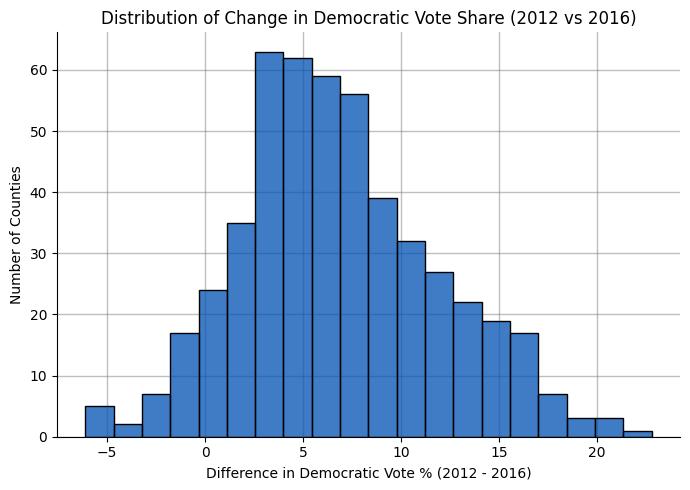

In [25]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot a histogram of the 'diff' column (change in Democratic vote %) with 20 bins
sns.histplot(
    sample_dem_data["diff"], ax=ax, bins=20, color="#0050B3", edgecolor="black"
)

sns.despine()

ax.set(
    xlabel="Difference in Democratic Vote % (2012 - 2016)",
    ylabel="Number of Counties",
    title="Distribution of Change in Democratic Vote Share (2012 vs 2016)",
)

ax.grid(True, alpha=0.5, linewidth=1, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Using ttest()
Manually calculating test statistics and transforming them with a CDF to get a p-value is a lot of effort to compare two sample means. The comparison of two sample means is called a t-test, and the `pingouin` Python package has a `.ttest()` method to accomplish it. This method provides some flexibility in how you perform the test.

As in the previous exercise, you'll explore the difference between the proportion of county-level votes for the Democratic candidate in 2012 and 2016 to identify if the difference is significant. The hypotheses are as follows:

$H_0$: The proportion of democratic votes in 2012 and 2016 were the same. <br>
$H_A$: The proportion of democratic votes in 2012 and 2016 were different.

In [26]:
import pingouin

# Perform a one-sample t-test on the 'diff' column to test if the mean difference is significantly different from zero
# This tests the null hypothesis that the average change in Democratic vote share is zero (no change between 2012 and 2016)
# The alternative="two-sided" specifies a two-tailed test: we are interested in any difference, not just an increase or decrease
test_results = pingouin.ttest(
    x=sample_dem_data["diff"],  # The observed differences in vote share
    y=0,  # The hypothesized mean difference under the null hypothesis
    alternative="two-sided",  # Two-sided test: checks for any significant change
)

# Perform a paired t-test comparing the Democratic vote percentages in 2012 and 2016 for each county
# This tests whether the mean vote share in 2012 is significantly different from that in 2016, accounting for the paired nature of the data
# The paired t-test is appropriate because each county provides both a 2012 and a 2016 value (dependent samples)
paired_test_results = pingouin.ttest(
    x=sample_dem_data["dem_percent_12"],  # Democratic vote percentage in 2012
    y=sample_dem_data["dem_percent_16"],  # Democratic vote percentage in 2016
    paired=True,
    alternative="two-sided",  # Two-sided test: checks for any significant change
)

display(paired_test_results)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,30.298384,499,two-sided,3.600634e-115,"[6.39, 7.27]",0.454202,2.246e+111,NaN


## The Problem: Comparing Multiple Groups

While a t-test is the appropriate tool for comparing the means of two groups, it is not suitable for comparing three or more groups simultaneously. Performing multiple t-tests on all possible pairs of groups (e.g., A vs. B, A vs. C, B vs. C) on the same data dramatically increases the probability of committing a **Type I error** (a false positive). Each test has an $\\alpha$ chance of being wrong, and these chances accumulate as you perform more tests.

The correct approach is a two-step process: first, use an omnibus test (ANOVA) to see if *any* difference exists, and second, if a difference is found, use adjusted pairwise tests to find out where it is.


### Analysis of Variance (ANOVA)

**ANOVA** is a statistical test that determines whether there are any statistically significant differences between the means of three or more independent groups. It works by comparing the amount of variation **between** the different groups to the amount of variation **within** each group.

#### Hypotheses for ANOVA

  * **Null Hypothesis ($H\_0$)**: The population means of all groups are equal.
    $$H_0: \mu_1 = \mu_2 = \dots = \mu_k$$
  * **Alternative Hypothesis ($H\_A$)**: At least one group mean is different from the others.

The ANOVA test is an **omnibus test**. A significant result (a small p-value) tells you that there is a difference *somewhere* among the groups, but it does not tell you which specific groups are different from each other.

#### ANOVA in Python with `pingouin`

The `pingouin` library provides a user-friendly interface for conducting statistical tests. The `pingouin.anova()` function is straightforward to use. You must first install the library: `pip install pingouin`.

```python
import pandas as pd
import numpy as np
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

# Create a generic, reproducible dataset with multiple groups
np.random.seed(42)
group_means = {'Group A': 50, 'Group B': 55, 'Group C': 50}
df = pd.DataFrame({
    'group': np.random.choice(list(group_means.keys()), 200),
    'value': 0.0 # Placeholder
})
df['value'] = df['group'].apply(lambda g: np.random.normal(loc=group_means[g], scale=5))

# Visualize the group distributions
sns.boxplot(x='group', y='value', data=df)
plt.title('Value Distribution by Group')
plt.show()

# Perform the ANOVA test
# dv: dependent variable (numeric)
# between: the grouping variable (categorical)
anova_results = pingouin.anova(data=df, dv='value', between='group')
print(anova_results)
```

To interpret the result, we look at the p-value (`p-unc`). If `p-unc < α` (our chosen significance level, e.g., 0.05), we reject the null hypothesis and conclude that at least one group mean is different.


### Pinpointing the Difference: Pairwise Tests with P-Value Adjustment

If the ANOVA test is significant, we proceed to the second step: **pairwise t-tests** to compare each group against every other group.

#### The Problem of Multiple Comparisons

As mentioned, running many t-tests inflates the Type I error rate. To counteract this, we must apply a **p-value adjustment**. These methods modify the raw p-values from each t-test to control the overall false positive rate for the entire family of tests.

#### Pairwise Tests with Bonferroni Correction

The **Bonferroni correction** is one of the simplest and most common adjustment methods. It mitigates the issue of multiple comparisons by multiplying each individual p-value by the number of tests being performed. This makes it "harder" for any single test to be declared significant, thereby controlling the overall error rate.

The `pingouin.pairwise_tests()` function can perform this entire process automatically.

```python
# Perform pairwise t-tests with Bonferroni correction 
# padjust='bonf' applies the correction
pairwise_results = pingouin.pairwise_tests(
    data=df,
    dv='value',
    between='group',
    padjust='bonf' # Specify the p-value adjustment method
)

# We are interested in the 'p-corr' (corrected p-value) column
print(pairwise_results[['A', 'B', 'p-unc', 'p-corr']])
```

**Interpretation**:
You examine the **`p-corr`** (corrected p-value) column. If a `p-corr` for a specific pair of groups (e.g., 'Group A' vs. 'Group B') is less than your significance level $\\alpha$, you can conclude that there is a statistically significant difference between the means of those two specific groups. `pingouin` offers several other adjustment methods via the `padjust` argument, such as `'holm'` or `'fdr_bh'`, which are often less conservative than the Bonferroni correction.

In [27]:
stack_overflow["job_sat"].value_counts()

job_sat
Very satisfied           879
Slightly satisfied       680
Slightly dissatisfied    342
Neither                  201
Very dissatisfied        159
Name: count, dtype: int64

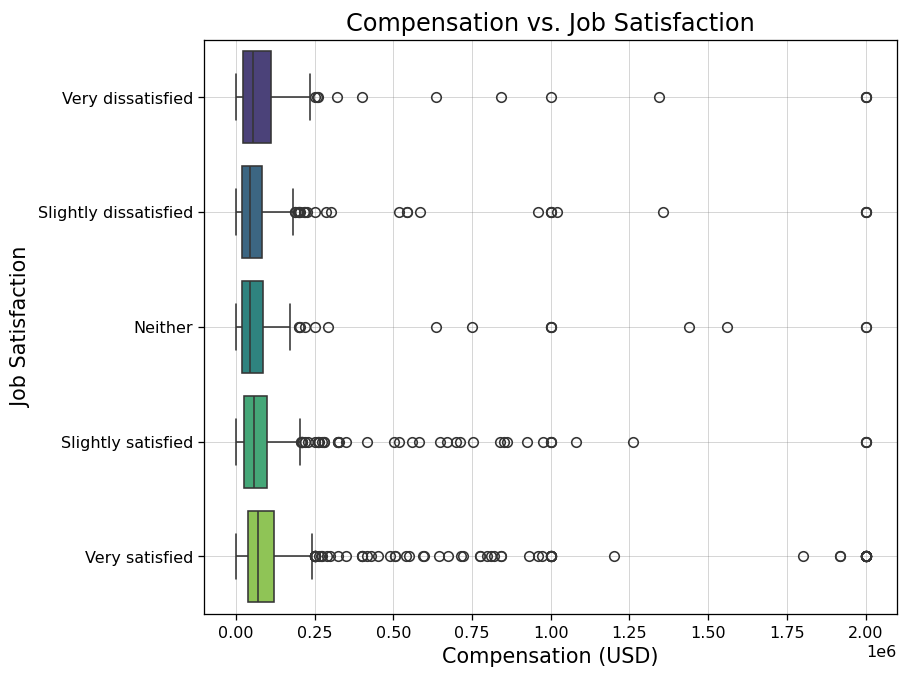

In [28]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=115)

with sns.axes_style("darkgrid", {"axes.facecolor": ".7"}):
    sns.boxplot(
        x="converted_comp",
        y="job_sat",
        data=stack_overflow,
        ax=ax,
        hue="job_sat",
        palette="viridis",
    )

ax.set_xlabel("Compensation (USD)", fontsize=13, fontname="DejaVu Sans")
ax.set_ylabel("Job Satisfaction", fontsize=13, fontname="DejaVu Sans")
ax.set_title("Compensation vs. Job Satisfaction", fontsize=15, fontname="DejaVu Sans")

ax.grid(True, alpha=0.5, linewidth=0.4, color="grey")
plt.tight_layout()
plt.show()

This block fits an ordinary least squares (OLS) regression model to test if compensation differs by job satisfaction group.<br>

The formula `"converted_comp ~ job_sat"` models compensation as a function of job satisfaction.<br>

`sm.stats.anova_lm()` performs an ANOVA (analysis of variance) to compare group means, outputting F-statistic and p-value.<br>

Statistically, this tests the null hypothesis that all job satisfaction groups have the same mean compensation.<br>

If the `p-value` for `job_sat` is below the chosen alpha (here, 0.2), we reject the null and conclude at least one group differs.<br>

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set the significance level (alpha) for the ANOVA test; this is the threshold for statistical significance
alpha = 0.2

# Fit an Ordinary Least Squares (OLS) regression model with compensation as the dependent variable and job satisfaction as the categorical predictor
model = ols(formula="converted_comp ~ job_sat", data=stack_overflow).fit()

# Perform an ANOVA (Analysis of Variance) on the fitted model to test if mean compensation differs by job satisfaction group
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA results, which show whether there is a statistically significant difference in compensation between job satisfaction groups
display(anova_table)

,sum_sq,df,F,PR(>F)
job_sat,1.256118e+12,4.0,4.480485,0.001315
Residual,1.581191e+14,2256.0,NaN,NaN


This block uses statsmodels' MultiComparison to perform pairwise t-tests between all job satisfaction groups for compensation.<br>

The `.allpairtest()` method applies t-tests for each pair, with Bonferroni correction for multiple comparisons.<br>

The result is a `SimpleTable`, which is converted to a pandas `DataFrame` for easier viewing.<br>

Statistically, this identifies which job satisfaction groups differ significantly in compensation, controlling for family-wise error rate.

In [30]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

# Create a MultiComparison object to compare compensation across job satisfaction groups
# This sets up all possible pairwise comparisons between job satisfaction categories for compensation
mc = MultiComparison(stack_overflow["converted_comp"], stack_overflow["job_sat"])

# Perform all pairwise t-tests between job satisfaction groups, using Bonferroni correction for multiple comparisons
# The Bonferroni method adjusts p-values to control the family-wise error rate when making many comparisons
result = mc.allpairtest(sm.stats.ttest_ind, method="bonf")

# Extract the summary table (SimpleTable object) from the result tuple
summary_table = result[0]  # SimpleTable object

# Convert the summary table to a pandas DataFrame for easier inspection and further analysis
anova_like_table = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])

display(anova_like_table)

,group1,group2,stat,pval,pval_corr,reject
0,Neither,Slightly dissatisfied,0.6277,0.5305,1.0000,False
1,Neither,Slightly satisfied,0.8541,0.3933,1.0000,False
2,Neither,Very dissatisfied,-0.5527,0.5808,1.0000,False
3,Neither,Very satisfied,-1.5374,0.1245,1.0000,False
4,Slightly dissatisfied,Slightly satisfied,0.0410,0.9673,1.0000,False
5,Slightly dissatisfied,Very dissatisfied,-1.2430,0.2145,1.0000,False
6,Slightly dissatisfied,Very satisfied,-2.7201,0.0066,0.0662,False
7,Slightly satisfied,Very dissatisfied,-1.6546,0.0984,0.9838,False
8,Slightly satisfied,Very satisfied,-3.7795,0.0002,0.0016,True
9,Very dissatisfied,Very satisfied,-0.7371,0.4612,1.0000,False


The `pingouin.pairwise_tests()` function performs pairwise statistical comparisons between groups.<br>

The `between` argument specifies the grouping variable, and `padjust="bonf"` applies Bonferroni correction for multiple comparisons.<br>

The output includes test statistics, raw and corrected p-values, and a reject column indicating significance at the default `alpha=0.05`.<br>

Statistically, this helps identify which job satisfaction groups differ significantly in compensation after adjusting for multiple testing.<br>

### Available P-Value Adjustment Methods

The `padjust` parameter offers several methods for controlling Type I error in multiple comparisons:

| Method | Description |
|--------|-------------|
| `'none'` | No correction (default) - uses raw p-values |
| `'bonf'` | One-step Bonferroni correction - most conservative |
| `'sidak'` | One-step Šidák correction - slightly less conservative than Bonferroni |
| `'holm'` | Step-down Holm-Bonferroni method - less conservative than Bonferroni |
| `'fdr_bh'` | Benjamini-Hochberg False Discovery Rate correction |
| `'fdr_by'` | Benjamini-Yekutieli False Discovery Rate correction |

**Recommendation**: Use `'bonf'` for strict control of family-wise error rate, or `'fdr_bh'` for better power while controlling false discovery rate.


In [31]:
# Perform pairwise t-tests comparing mean compensation ("converted_comp") between all job satisfaction ("job_sat") groups in the Stack Overflow dataset
pingouin.pairwise_tests(
    # The dataset containing compensation and job satisfaction columns
    data=stack_overflow,
    # The dependent variable: compensation in USD
    dv="converted_comp",
    # The grouping variable: job satisfaction category
    between="job_sat",
    # Apply Bonferroni correction to adjust p-values for multiple comparisons, controlling the family-wise error rate
    padjust="bonf",
)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,job_sat,Very dissatisfied,Slightly dissatisfied,False,True,1.129951,247.570187,two-sided,0.259590,1.000000,bonf,0.197,0.119131
1,job_sat,Very dissatisfied,Neither,False,True,0.545948,321.165726,two-sided,0.585481,1.000000,bonf,0.135,0.058537
2,job_sat,Very dissatisfied,Slightly satisfied,False,True,1.243665,187.153329,two-sided,0.215179,1.000000,bonf,0.208,0.145624
3,job_sat,Very dissatisfied,Very satisfied,False,True,-0.747379,221.666205,two-sided,0.455627,1.000000,bonf,0.126,-0.063479
4,job_sat,Slightly dissatisfied,Neither,False,True,-0.602209,367.730081,two-sided,0.547406,1.000000,bonf,0.118,-0.055707
5,job_sat,Slightly dissatisfied,Slightly satisfied,False,True,0.038264,569.926329,two-sided,0.969491,1.000000,bonf,0.074,0.002719
6,job_sat,Slightly dissatisfied,Very satisfied,False,True,-3.076222,821.303063,two-sided,0.002166,0.021659,bonf,7.43,-0.173247
7,job_sat,Neither,Slightly satisfied,False,True,0.700752,258.204546,two-sided,0.484088,1.000000,bonf,0.114,0.068513
8,job_sat,Neither,Very satisfied,False,True,-1.662901,328.326639,two-sided,0.097286,0.972864,bonf,0.337,-0.120115
9,job_sat,Slightly satisfied,Very satisfied,False,True,-4.009935,1478.622799,two-sided,0.000064,0.000638,bonf,158.564,-0.192931


In [32]:
# Group the late_shipments DataFrame by the 'shipment_mode' column and calculate the mean of 'pack_price' for each group.
# This gives the average pack price for each shipment mode, helping us compare central tendencies across categories.
xbar_pack_by_mode = late_shipments.groupby("shipment_mode")["pack_price"].mean()

# Group the late_shipments DataFrame by 'shipment_mode' and calculate the standard deviation of 'pack_price' for each group.
# The standard deviation measures the spread or variability of pack prices within each shipment mode group.
s_pack_by_mode = late_shipments.groupby("shipment_mode")["pack_price"].std()

display(s_pack_by_mode)

shipment_mode
Air            48.932861
Air Charter     0.992969
Ocean           5.303047
Name: pack_price, dtype: float64

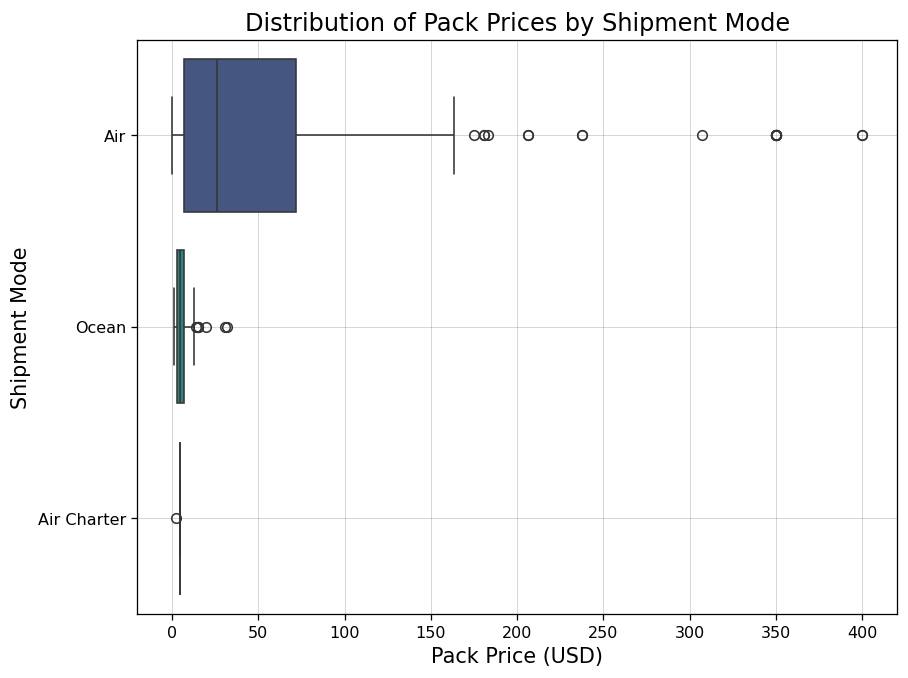

In [33]:
# Create a boxplot from late_shipments with "pack_price" as x and "shipment_mode" as y.
fig, ax = plt.subplots(figsize=(8, 6), dpi=115)

with sns.axes_style("darkgrid", {"axes.facecolor": ".7"}):
    sns.boxplot(
        x="pack_price",
        y="shipment_mode",
        data=late_shipments,
        ax=ax,
        palette="viridis",
        hue="shipment_mode",
    )

ax.set_xlabel("Pack Price (USD)", fontsize=13, fontname="DejaVu Sans")
ax.set_ylabel("Shipment Mode", fontsize=13, fontname="DejaVu Sans")
ax.set_title(
    "Distribution of Pack Prices by Shipment Mode",
    fontsize=15,
    fontname="DejaVu Sans",
)
ax.grid(True, alpha=0.5, linewidth=0.4, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Conducting an ANOVA test
The box plots made it look like the distribution of pack price was different for each of the three shipment modes. However, it didn't tell us whether the mean pack price was different in each category. To determine that, we can use an ANOVA test. The null and alternative hypotheses can be written as follows.

$H_0$: Pack prices for every category of shipment mode are the same.<br>
$H_A$: Pack prices for some categories of shipment mode are different.


Use a significance level of 0.1.

In [34]:
# Run an ANOVA (Analysis of Variance) to test if the mean pack price differs across shipment modes
# This tests the null hypothesis that all shipment_mode groups have the same mean pack_price
anova_results = pingouin.anova(
    # DataFrame containing the data to analyze
    data=late_shipments,
    # Dependent variable: the numeric variable whose means are compared
    dv="pack_price",
    # Categorical variable defining the groups to compare
    between="shipment_mode",
)

# A small p-value (below alpha) indicates at least one group mean is significantly different
print(anova_results)

          Source  ddof1  ddof2        F         p-unc       np2
0  shipment_mode      2    997  21.8646  5.089479e-10  0.042018


In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit an Ordinary Least Squares (OLS) regression model
# This models 'pack_price' as a function of the categorical variable 'shipment_mode'
# Statistically, this is equivalent to comparing the mean pack price across shipment modes (ANOVA)
model = ols(formula="pack_price ~ shipment_mode", data=late_shipments).fit()

# Perform an ANOVA (Analysis of Variance) on the fitted model
# This tests the null hypothesis that all shipment_mode groups have the same mean pack_price
# The output includes the F-statistic and associated p-value for the group variable
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA results table
# If the p-value for 'shipment_mode' is below your chosen alpha, you reject the null hypothesis
print(anova_table)

                     sum_sq     df        F        PR(>F)
shipment_mode  9.515185e+04    2.0  21.8646  5.089479e-10
Residual       2.169406e+06  997.0      NaN           NaN


In [36]:
# Perform pairwise t-tests to compare the mean pack price between each pair of shipment modes in the late_shipments dataset
pingouin.pairwise_tests(
    # DataFrame containing the data to analyze
    data=late_shipments,
    # Dependent variable: the numeric variable whose means are compared
    dv="pack_price",
    # Categorical variable defining the groups to compare
    between="shipment_mode",
    # No p-value adjustment: each test's p-value is reported as-is (risk of inflated Type I error if many comparisons)
    padjust=None,
)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,shipment_mode,Air,Air Charter,False,True,21.179625,600.685682,two-sided,8.748346e-75,5.809e+76,0.726592
1,shipment_mode,Air,Ocean,False,True,19.335760,986.979785,two-sided,6.934555e-71,1.129e+67,0.711119
2,shipment_mode,Air Charter,Ocean,False,True,-3.170654,35.615026,two-sided,3.123012e-03,15.277,-0.423775


In [37]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

# Set up a MultiComparison object to compare pack prices across shipment modes
# This object enables all possible pairwise comparisons between the categories in 'shipment_mode'
mc = MultiComparison(late_shipments["pack_price"], late_shipments["shipment_mode"])

# Perform all pairwise t-tests between shipment modes, using Bonferroni correction to control for multiple comparisons
# The Bonferroni method adjusts p-values to reduce the risk of Type I error when making many comparisons
result = mc.allpairtest(sm.stats.ttest_ind, method="bonf")

# Extract the summary table (SimpleTable object) containing the results of all pairwise tests
summary_table = result[0]  # SimpleTable object

# Convert the summary table to a pandas DataFrame for easier inspection and further analysis
anova_like_table = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])

display(anova_like_table)

,group1,group2,stat,pval,pval_corr,reject
0,Air,Air Charter,1.7754,0.0762,0.2285,False
1,Air,Ocean,6.3736,0.0000,0.0000,True
2,Air Charter,Ocean,-1.0126,0.3139,0.9417,False


## From Bootstrapping to a Direct Formula

Previously, we determined the significance of a point estimate by a four-step process:

1.  Generate a bootstrap distribution to approximate the sampling distribution.
2.  Calculate the standard error as the standard deviation of the bootstrap distribution.
3.  Compute a standardized test statistic (z-score) using this standard error.
4.  Calculate a p-value from the test statistic to make a decision.

For tests involving proportions, there is a more direct, analytical method that bypasses the need for the computationally intensive bootstrap simulation. This method allows us to calculate the standard error and the z-statistic directly from a known formula.

### The Standardized Test Statistic for Proportions

The general formula for a standardized test statistic is:

$$z = \frac{\text{Sample Statistic} - \text{Hypothesized Parameter}}{SE(\text{Sample Statistic})}$$

For a one-sample test of a proportion, the specific terms are:

  * **Sample Statistic**: $\hat{p}$, the observed sample proportion.
  * **Hypothesized Parameter**: $p_0$, the population proportion assumed under the null hypothesis.
  * **Standard Error**: $SE(\hat{p})$, the standard error of the sample proportion.
  Assuming the null hypothesis is true ($H_0: p = p_0$), the formula becomes:

$$z = \frac{\hat{p} - p_0}{SE(\hat{p})}$$

### A Simplified Standard Error

The key to bypassing the bootstrap is having a direct formula for the standard error. The logic of hypothesis testing requires us to assume the null hypothesis is true. Under this assumption, our best guess for the true population proportion is the hypothesized value, $p_0$. Therefore, we use $p_0$ to calculate the standard error.

The standard error for a sample proportion, under the null hypothesis, is:

$$SE(\hat{p}) = \sqrt{\frac{p_0(1-p_0)}{n}}$$

By substituting this simplified standard error back into the z-statistic formula, we arrive at the final test statistic, which can be calculated without any simulation:

$$z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}$$

This powerful formula depends only on the sample proportion ($\hat{p}$), the sample size (`n`), and the hypothesized proportion ($p_0$).

### Why a z-test and not a t-test?

We use a **t-test** when we must estimate a population standard deviation ($\sigma$) from our sample standard deviation (`s`). This estimation introduces extra uncertainty, which is accounted for by the "fatter tails" of the t-distribution.

For a proportion test, the situation is different. The variability of a proportion is intrinsically linked to its value. Under the null hypothesis, the standard error is *fully determined* by the hypothesized proportion ($p_0$) and the sample size (`n`). We are not estimating a separate standard deviation parameter from the sample. Since this extra source of uncertainty is absent, the z-distribution is appropriate.


### A Complete Example: One-Sample Proportion Test

Let's conduct a complete one-sample proportion test using this direct analytical method.

**Scenario**: A company claims that 25% of its website visitors make a purchase. We take a sample of 1000 visitors and find that 280 of them made a purchase. Is there significant evidence to suggest the true proportion is different from 25%?

```python
import numpy as np
from scipy.stats import norm

# 1. State Hypotheses and Define Parameters 
# H0: The true proportion of purchasing visitors is 0.25. (p = 0.25)
# HA: The true proportion is not 0.25. (p ≠ 0.25) -> This is a two-tailed test.

p_0 = 0.25  # Hypothesized population proportion
n = 1000    # Sample size
p_hat = 280 / 1000 # Observed sample proportion
alpha = 0.05 # Significance level

# 2. Calculate the z-statistic
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1 - p_0) / n)
z_score = numerator / denominator

print(f"Sample Proportion (p-hat): {p_hat:.4f}")
print(f"Hypothesized Proportion (p_0): {p_0}")
print(f"Z-score: {z_score:.4f}")

# 3. Calculate the p-value
# For a two-tailed test, we find the area in the tails beyond |z_score|
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"\nP-value: {p_value:.4f}")

# 4. Make a Statistical Decision 
if p_value < alpha:
    print(f"\nDecision: Reject H0, because p ({p_value:.4f}) < alpha ({alpha}).")
    print("The evidence suggests the true proportion of purchasing visitors is different from 0.25.")
else:
    print(f"\nDecision: Fail to reject H0, because p ({p_value:.4f}) >= alpha ({alpha}).")
    print("There is not enough evidence to conclude the proportion is different from 0.25.")
```

The small p-value allows us to reject the null hypothesis, concluding that our sample provides strong evidence that the true proportion of visitors who make a purchase is not 25%.